Epoch [1/100], Loss: 1.1037, Accuracy: 56.36%
Epoch [2/100], Loss: 0.7710, Accuracy: 71.23%
Epoch [3/100], Loss: 0.6346, Accuracy: 76.45%
Epoch [4/100], Loss: 0.5382, Accuracy: 80.38%
Epoch [5/100], Loss: 0.4730, Accuracy: 82.60%
Epoch [6/100], Loss: 0.4143, Accuracy: 85.00%
Epoch [7/100], Loss: 0.3683, Accuracy: 86.50%
Epoch [8/100], Loss: 0.3264, Accuracy: 87.93%
Epoch [9/100], Loss: 0.2952, Accuracy: 89.48%
Epoch [10/100], Loss: 0.2606, Accuracy: 90.76%
Epoch [11/100], Loss: 0.2376, Accuracy: 91.64%
Epoch [12/100], Loss: 0.2105, Accuracy: 92.49%
Epoch [13/100], Loss: 0.1906, Accuracy: 93.13%
Epoch [14/100], Loss: 0.1680, Accuracy: 94.08%
Epoch [15/100], Loss: 0.1516, Accuracy: 94.80%
Epoch [16/100], Loss: 0.1373, Accuracy: 95.24%
Epoch [17/100], Loss: 0.1317, Accuracy: 95.26%
Epoch [18/100], Loss: 0.1106, Accuracy: 96.24%
Epoch [19/100], Loss: 0.1084, Accuracy: 96.28%
Epoch [20/100], Loss: 0.0994, Accuracy: 96.57%
Epoch [21/100], Loss: 0.0933, Accuracy: 96.73%
Epoch [22/100], Loss: 

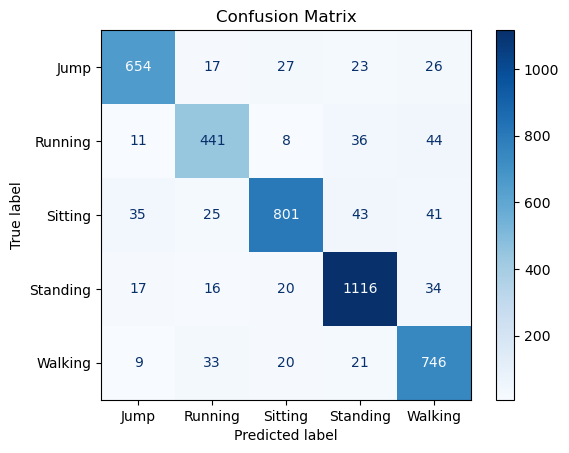

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

# Load the dataset
data = pd.read_csv('./Data/Wireless Eye Data/Training Data/LoS/combined1_training.csv')

# Preprocess the data
X = data.drop(['timestamp', 'activity'], axis=1).values  # Drop irrelevant columns
y = data['activity'].values  # Target column

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create Dataset class
class ActivityDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = ActivityDataset(X_train, y_train)
test_dataset = ActivityDataset(X_test, y_test)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Define the LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        # Forward propagate through LSTM
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Decode last time step
        return out

# Model parameters
input_size = X_train.shape[1]
hidden_size = 128
num_layers = 2
num_classes = len(np.unique(y))

model = LSTMClassifier(input_size, hidden_size, num_layers, num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# TensorBoard setup
writer = SummaryWriter(log_dir="runs/activity_recognition")

# Training the model
num_epochs = 100
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    epoch_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        outputs = model(inputs.unsqueeze(1))  # Add a time dimension
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for the epoch
    epoch_loss /= len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Log to TensorBoard
    writer.add_scalar('Loss/Train', epoch_loss, epoch)
    writer.add_scalar('Accuracy/Train', epoch_accuracy, epoch)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

# Evaluate the model
model.eval()  # Set model to evaluation mode
true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.unsqueeze(1))  # Add a time dimension
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())

# Compute test accuracy
test_accuracy = 100 * np.sum(np.array(predicted_labels) == np.array(true_labels)) / len(true_labels)
writer.add_scalar('Accuracy/Test', test_accuracy, num_epochs)
print(f'Accuracy of the model on the test set: {test_accuracy:.2f}%')

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Close TensorBoard writer
writer.close()